# NLP Project, Classification of Amazon Reviews and Key Phrases - GRU MODEL
#### CSCI 3832 Natural Language Processing
Members: Adam Wuth, Benjamin Kohav, Noah Vilas, Aiden Devine, Evan Zachary

### Requirements

In order to run, make sure that all the below dependencies are installed and the filtered amazon review folder is populated. Once those requirements are satisfied, just run all of the cells sequentially. The parameters input on the GRU model already are the ones that were used to make the graphs, but in case it's not clear, the embedding size is 175, hidden dimensions is 256, the number of hidden layers is 5, epochs is 5, and batch size is 256.

In [2]:
import os, random, sys, copy
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from datasets import load_dataset, concatenate_datasets, load_from_disk
from datetime import datetime
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from collections import Counter

### Load in the data set
The dataset is split into categories, but we wanted all categories from 2020 onwards. This code block will take forever to run, only run it the first time to get the dataset. 

In [3]:
#The dataset is split into categories

categories = [
    "All_Beauty",
    "Amazon_Fashion",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Beauty_and_Personal_Care",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Clothing_Shoes_and_Jewelry",
    "Digital_Music",
    "Electronics",
    "Gift_Cards",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health_and_Household",
    "Health_and_Personal_Care",
    "Home_and_Kitchen",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Magazine_Subscriptions",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Subscription_Boxes",
    "Tools_and_Home_Improvement",
    "Toys_and_Games",
    "Video_Games",
    "Unknown"
]


limit = 589  # 100,000 target reviews 34 categories 5 stars, (100,000/34)/5 = 889

allcats = []

reviews = load_from_disk("filetred_amazon_reviews")
print(Counter(reviews["rating"])) 
print(f"Total reviews loaded: {len(reviews)}")
Counter({1.0: 20026, 2.0: 20026, 3.0: 20026, 4.0: 20026, 5.0: 20026})



Counter({1.0: 20026, 2.0: 20026, 3.0: 20026, 4.0: 20026, 5.0: 20026})
Total reviews loaded: 100130


Counter({1.0: 20026, 2.0: 20026, 3.0: 20026, 4.0: 20026, 5.0: 20026})

If you have run that already, reviews was saved(should be in the working directory)so you can just do the next code block instead

In [4]:
reviews = load_from_disk("filetred_amazon_reviews")
print(len(reviews))
print(reviews[0])
print(reviews[1])
print(reviews.column_names)

100130
{'rating': 1.0, 'title': 'Worst nail polish ever', 'text': 'Worst nail polish ever! My daughter and I both used this nail polish in two different colors and now our nails are damaged. Our nails split horizontally and are peeling. Plus the damage has caused pain. Worst Sally Hansen product ever!', 'images': [], 'asin': 'B011855ADM', 'parent_asin': 'B011855ADM', 'user_id': 'AEMVAG56MA7MAFULCQJEOVJCKGHA', 'timestamp': 1454738837000, 'helpful_vote': 8, 'verified_purchase': True}
{'rating': 1.0, 'title': 'No funciona para mi', 'text': 'Bueno en cuanto a mi respondo que no me funciono. Tengo pocas pestañas, las enchufe antes de poner la máscara y el resultado desastroso. El producto hizo que mis pestañas perdieran el volumen del encrespado horrible.', 'images': [], 'asin': 'B09GTV6WL6', 'parent_asin': 'B09GTV6WL6', 'user_id': 'AFPNHXMEBYKO3SPMFXZCALLZ5IHA', 'timestamp': 1645820993736, 'helpful_vote': 5, 'verified_purchase': True}
['rating', 'title', 'text', 'images', 'asin', 'parent_a

### Load in the Glove Embeddings

In [5]:
glove_file = './glove.6B.50d.txt' # modify to appropriate path for your file system

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed


print('Loaded {} words from glove'.format(len(embeddings_dict)))

low = -1.0 / 3
high = 1.0 / 3
embedding_matrix = np.random.uniform(low=low, high=high, size=(len(embeddings_dict)+1, 50))

word2id = {}
for i, word in enumerate(embeddings_dict.keys(), 1):

    word2id[word] = i                                
    embedding_matrix[i] = embeddings_dict[word]      

word2id['<pad>'] = 0

Loaded 400001 words from glove


### Set up train and validation datasets

In [ ]:
class GRUMovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset=None, word2id=None, finalized_data=None, data_limit=250, max_length=128, tokenize=True):
        """
        :param hf_dataset: A Hugging Face Dataset object
        :param word2id: Dictionary mapping words to integer indices
        :param finalized_data: Pre-tokenized and processed data
        :param data_limit: Max number of examples to use
        :param max_length: Max sequence length
        :param tokenize: Whether to tokenize the text input
        """
        self.data_limit = data_limit
        self.max_length = max_length
        self.word2id = word2id or {}

        # Ensure <pad> and <unk> tokens exist
        self.word2id.setdefault('<pad>', 0)
        self.word2id.setdefault('unk', len(self.word2id))

        if finalized_data:
            self.data = finalized_data
        else:
            examples, labels = [], []
            for i, example in enumerate(hf_dataset):
                if i >= self.data_limit:
                    break
                examples.append(example["text"])
                labels.append(int(example["rating"]) - 1)  # Convert 1–5 to 0–4

            tokenized = self.tokenize(examples) if tokenize else examples
            self.data = [(ids, length, label) for (ids, length), label in zip(tokenized, labels)]

            random.seed(42)
            random.shuffle(self.data)

    def tokenize(self, examples):
        example_ids = []
        misses, total = 0, 0
        for example in tqdm(examples):
            if not example.strip():  # Skip empty strings
                continue
            tokens = word_tokenize(example)
            ids = []
            for tok in tokens:
                if tok in self.word2id:
                    ids.append(self.word2id[tok])
                else:
                    misses += 1
                    ids.append(self.word2id['unk'])
                total += 1

            length = min(len(ids), self.max_length)
            ids = ids[:self.max_length]
            ids += [self.word2id['<pad>']] * (self.max_length - len(ids))

            example_ids.append((torch.LongTensor(ids), length))
        print(f'Missed {misses} out of {total} words -- {misses/total:.2%}')
        return example_ids

    def generate_validation_split(self, ratio=0.8):
        split_idx = int(ratio * len(self.data))
        val_split = self.data[split_idx:]
        self.data = self.data[:split_idx]
        return val_split

    def __getitem__(self, index):
        return self.data[index]  # (input_ids, length, label)

    def __len__(self):
        return len(self.data)

In [7]:
#also modified from hw3
train_dataset = GRUMovieReviewDataset(hf_dataset=reviews, word2id=word2id, data_limit=100000)
validation_examples = train_dataset.generate_validation_split()
print('Loaded {} train examples'.format(len(train_dataset)))

valid_dataset = GRUMovieReviewDataset(finalized_data=validation_examples, word2id=word2id)
print('Loaded {} validation examples'.format(len(valid_dataset)))

print(valid_dataset[0])  # (input_ids, length, label)

  0%|          | 0/100000 [00:00<?, ?it/s]

Missed 702896 out of 6132095 words -- 11.46%
Loaded 79972 train examples
Loaded 19993 validation examples
(tensor([201535,     87,   3072,   2160,    170, 201535,      5,    425,      1,
          4513,      3, 201535,     45,     15,     85,   6397,      3,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             

In [8]:
input_ids, length, label = valid_dataset[1]
print("True length:", length)
print("Non-padded input:", input_ids[:length])
print("Label:", label)


True length: 113
Non-padded input: tensor([201535,     15,    171,  19613,    540,   2704,     18,  15826,   2154,
             6,     30,  12793,   5352,      3, 201535,      6,     27,    703,
        201535,    162,     14,   1351,    847,   2375,   1511,    272,      3,
        201535,      6,     27,  51703,  18056,     34,     45,   1282,    550,
            18,      1,   5567,      4,      8,   4552,   1750,      3, 201535,
          1750,     10,    630,     15,     37,      8,    815,   3942,      7,
        201535,      6,     15,  44384,      5,     27,    703,      3, 201535,
          3519,      2,      1, 201535,     10,    973,     15,  14159,     22,
         40871,   2331,     43,  78362,    104,      5,     85,    157,    806,
        201535,   9770,      5,    597,   1511,      6,  12450,    272,   4216,
             1,   4334,    448,      7,      1,    524,      3, 201535,    524,
            53,   2245,     14,    193,  80968,      3, 201535,    282,     32,
     

# Define the GRU Classifier

In [22]:
import torch

import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          bidirectional=bidirectional, batch_first=True)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction_factor, output_size)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed)
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(hidden)

# Collate function required to offload the processing onto GPU

In [12]:
def collate_fn(batch):
    input_ids, lengths, labels = zip(*batch)
    input_ids = torch.stack(input_ids).to(device)
    lengths = torch.tensor(lengths).to(device)
    labels = torch.tensor(labels).to(device)
    return input_ids, lengths, labels

In [ ]:
# Training Loop
#75,128,batch 256, 5 epoch = 44%
#100,256,256,5 = 44%
#50,256,256,5 = 44%
#100,512,256,5 = 45%
#Initialize our model -- keep it small with 1 hidden layer, and embedding sizes of 50
from torch.utils.data import DataLoader
if __name__ == "__main__":
    epochs = 5
    batch_size = 256
    print_frequency = 1000

    vocab_size = len(word2id)
    GRU_model = GRUClassifier(vocab_size, embed_size=175, hidden_size=256, num_layers=5, output_size=5)
    GRU_model = GRU_model.to(device)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    criteria = nn.CrossEntropyLoss()
    #AdamW is a popularly used optimizer
    optimizer = torch.optim.RAdam(GRU_model.parameters())  

    # store average loss and accuracy values
    avg_loss_values = []
    avg_acc_values = []
    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')

        GRU_model.train()
        avg_loss = 0
        
        
        # ADDED Store loss for plotting
        loss_history = []  
        for step, data in enumerate(train_dataloader):
            GRU_model.train()
            input_ids, lengths, labels = data  # Unpack the data into input_ids, lengths, and labels
            input_ids, lengths, labels = input_ids.to(device), lengths.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with both input_ids and lengths
            model_output = GRU_model(input_ids, lengths)  # Pass both input_ids and lengths

            # Compute loss
            loss = criteria(model_output.squeeze(1), labels)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            #print frequency == 1
            if step % 1 == 0:
                avg_loss_values.append(avg_loss / print_frequency)
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss / print_frequency
                ))
                avg_loss = 0
            GRU_model.eval()
            val_loss = 0
            correct_preds = 0
            total_preds = 0

            with torch.no_grad():
                for data in valid_dataloader:
                    input_ids, lengths, labels = data
                    input_ids, lengths, labels = input_ids.to(device), lengths.to(device), labels.to(device)
                    model_output = GRU_model(input_ids, lengths)
                    loss = criteria(model_output.squeeze(1), labels)

                    val_loss += loss.item()
                    
                    # Calculate accuracy
                    _, predicted = torch.max(model_output, 1)
                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)

            # Print validation loss and accuracy
    
            val_loss /= len(valid_dataloader)
            val_accuracy = correct_preds / total_preds
            avg_acc_values.append(correct_preds/ total_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

### Epoch: 1 ###
epoch: 0 batch: 0 loss: 0.0016086324453353882
Validation Loss: 1.6112, Validation Accuracy: 0.2014
epoch: 0 batch: 1 loss: 0.0016130385398864745
Validation Loss: 1.6109, Validation Accuracy: 0.2015
epoch: 0 batch: 2 loss: 0.0016126601696014404
Validation Loss: 1.6111, Validation Accuracy: 0.2016
epoch: 0 batch: 3 loss: 0.001606222152709961
Validation Loss: 1.6110, Validation Accuracy: 0.2015
epoch: 0 batch: 4 loss: 0.0016120685338974
Validation Loss: 1.6111, Validation Accuracy: 0.2015
epoch: 0 batch: 5 loss: 0.0016067044734954833
Validation Loss: 1.6105, Validation Accuracy: 0.2017
epoch: 0 batch: 6 loss: 0.0016148900985717774
Validation Loss: 1.6101, Validation Accuracy: 0.2065
epoch: 0 batch: 7 loss: 0.0016083004474639893
Validation Loss: 1.6096, Validation Accuracy: 0.2142
epoch: 0 batch: 8 loss: 0.0016133642196655272
Validation Loss: 1.6087, Validation Accuracy: 0.2179
epoch: 0 batch: 9 loss: 0.0016086288690567016
Validation Loss: 1.6082, Validation Accuracy: 0.21

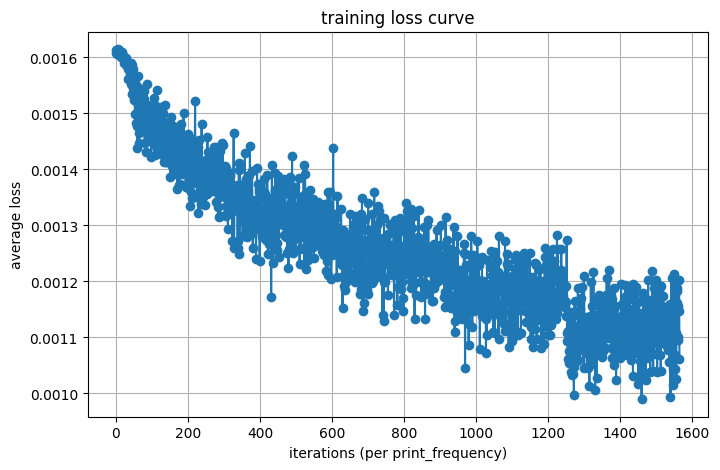

In [23]:
import os, random, sys, matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(avg_loss_values, marker='o', linestyle='-')
plt.xlabel('iterations (per print_frequency)')
plt.ylabel('average loss')
plt.title('training loss curve')
plt.grid()
plt.show()

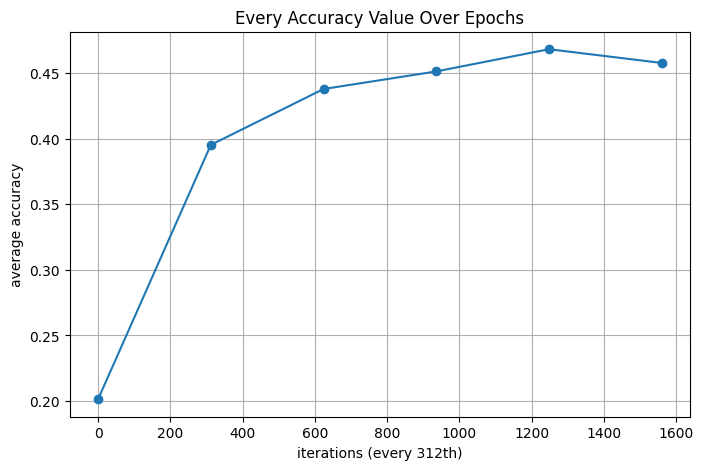

In [35]:
import os, random, sys, matplotlib.pyplot as plt

subset_indices = list(range(0, len(avg_acc_values), 312))
subset_values = [avg_acc_values[i] for i in subset_indices]

# Plot the selected values
plt.figure(figsize=(8, 5))
plt.plot(subset_indices, subset_values, marker='o', linestyle='-')
plt.xlabel('iterations (every 312th)')
plt.ylabel('average accuracy')
plt.title('Every Accuracy Value Over Epochs')
plt.grid()
plt.show()

# Function to test individual strings against the model

In [33]:
from nltk.tokenize import word_tokenize
import torch

def predict_sentiment(sentence, model, word2id, max_length=128):
    model.eval()  # set model to evaluation mode
    
    # Tokenize and convert to IDs
    tokens = word_tokenize(sentence.lower())
    ids = [word2id.get(tok, word2id['unk']) for tok in tokens]
    
    # Get actual length
    length = min(len(ids), max_length)
    
    # Pad or truncate
    ids = ids[:max_length] + [word2id['<pad>']] * (max_length - len(ids))
    
    # Convert to tensor and move to device
    input_ids = torch.tensor([ids], dtype=torch.long).to(device)
    lengths = torch.tensor([length], dtype=torch.long).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_ids, lengths)
        predicted_class = torch.argmax(output, dim=1).item()
    
    return predicted_class  # or map this to a label like "positive", "negative", etc.

# Example usage
sentence = "I like some parts about this product"
predicted_label = predict_sentiment(sentence, GRU_model, word2id)
print("Predicted label:", predicted_label+1)

Predicted label: 3
